*If running in Colab run this first to install ACN-Portal.*

In [ ]:
import subprocess
import sys

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    subprocess.check_call([sys.executable, "-m", "pip", "install", "acnportal"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "git+https://github.com/caltech-netlab/adacharge"])

# Unbalanced Three-Phase Infrastructure Constraints

Currently, most charging algorithms in the literature rely on constraints which assume single-phase or balanced three-phase operation. In this experiment, we demonstrate why these assumptions are insufficient for practical charging systems. 

For this experiment we use the consider two algorithms, 1) least-laxity first (LLF) and 2) Model Predictive Control (MPC). We also consider two cases, in the first we use a simplified single-phase representation of the constraints in the network. In the second, we use the full three-phase system model. In both cases, we evalaute the algorithms using the true three-phase network model.

In [ ]:
import pytz
from datetime import datetime
import numpy as np
# import cvxpy as cp
from copy import deepcopy
import time 
from matplotlib import pyplot as plt
from matplotlib import cm

from acnportal import acnsim
from acnportal.acnsim import analysis
from acnportal import algorithms
import adacharge

## Single-phase CaltechACN Network

In this *ChargingNetwork* we treat all EVSEs as if they were on the same phase by setting the phase angle for each to be 0. The only constraints for this model are that the aggregate rates of the AV and CC pods are less than 80 A and that the aggregate power of all EVSEs is less than the power limit of the transformer. 

(We assume nominal voltage in the network)

In [ ]:
def single_phase_caltech_acn(basic_evse=False, voltage=208, transformer_cap=150, network_type=acnsim.ChargingNetwork):
    """ Predefined single phase ChargingNetwork for the Caltech ACN.

    Args:
        basic_evse (bool): If True use BASIC EVSE type instead of actual AeroViroment and ClipperCreek types.
        voltage (float): Default voltage at the EVSEs. Does not affect the current rating of the transformer which is
            based on nominal voltages in the network. 277V LL for delta primary and 120V LN for wye secondary. [V]
        transformer_cap (float): Capacity of the transformer in the CaltechACN. Default: 150. [kW]

    Attributes:
        See ChargingNetwork for Attributes.
    """
    network = network_type()

    if basic_evse:
        evse_type = {'AV': 'BASIC', 'CC': 'BASIC'}
    else:
        evse_type = {'AV': 'AeroVironment', 'CC': 'ClipperCreek'}
        
    # Define the sets of EVSEs in the Caltech ACN.
    CC_pod_ids = ["CA-322", "CA-493", "CA-496", "CA-320", "CA-495", "CA-321", "CA-323", "CA-494"]
    AV_pod_ids = ["CA-324", "CA-325","CA-326","CA-327","CA-489", "CA-490", "CA-491", "CA-492"]
    other_ids = [f"CA-{id_num}" for id_num in [148, 149, 212, 213, 303, 304, 305, 306, 307, 308,
                                               309, 310, 311, 312, 313, 314, 315, 316, 317, 318,
                                               319, 497, 498, 499, 500, 501, 502, 503, 504, 505,
                                               506, 507, 508, 509, 510, 511, 512, 513]]
    all_ids = CC_pod_ids + AV_pod_ids + other_ids

    # Add Caltech EVSEs
    for evse_id in all_ids:
        if evse_id not in CC_pod_ids:
            network.register_evse(acnsim.get_evse_by_type(evse_id, evse_type['AV']), voltage, 0)
        else:
            network.register_evse(acnsim.get_evse_by_type(evse_id, evse_type['CC']), voltage, 0)
            
    # Add Caltech Constraint Set
    CC_pod = acnsim.Current(CC_pod_ids)
    AV_pod = acnsim.Current(AV_pod_ids)
    all_current = acnsim.Current(all_ids)

    # Build constraint set
    network.add_constraint(CC_pod, 80, name='CC Pod')
    network.add_constraint(AV_pod, 80, name='AV Pod')
    network.add_constraint(all_current, transformer_cap * 1000 / voltage, name='Transformer Cap')
    return network

## Experiment Setup

In [ ]:
def experiment(algorithm):
    """ Run single phase vs. three phase experiment for a particular algorithm. """
    # -- Experiment Parameters ---------------------------------------------------
    timezone = pytz.timezone('America/Los_Angeles')
    start = timezone.localize(datetime(2019, 3, 5))
    end = timezone.localize(datetime(2019, 3, 6))
    period = 5  # minute
    voltage = 208  # volts
    default_battery_power = 32 * voltage / 1000 # kW
    site = 'caltech'

    # -- Network -------------------------------------------------------------------
    single_phase_cn = single_phase_caltech_acn(basic_evse=True, transformer_cap=50)
    real_cn = acnsim.sites.caltech_acn(basic_evse=True, transformer_cap=50)

    # -- Events ---------------------------------------------------------------------
    API_KEY = 'DEMO_TOKEN'
    events = acnsim.acndata_events.generate_events(API_KEY, site, start, end, period, 
                                                   voltage, default_battery_power)
    
    # -- Single Phase ----------------------------------------------------------------
    single_phase_sim = acnsim.Simulator(deepcopy(single_phase_cn), algorithm, 
                                        deepcopy(events), start, period=period, 
                                        verbose=False)
    single_phase_sim.run()
    
    # Since we are interested in how the single-phase LLF algorithm would have performed 
    # in the real CaltechACN, we replace the network model with the real network model 
    # for analysis. 
    single_phase_sim.network = real_cn
    
    # -- Three Phase -----------------------------------------------------------------        
    three_phase_sim = acnsim.Simulator(deepcopy(real_cn), algorithm,
                                       deepcopy(events), start, period=period, 
                                       verbose=False)
    three_phase_sim.run()
    
    return single_phase_sim, three_phase_sim

## Running Experiment

### Least Laxity First

In [ ]:
llf = algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first)
llf_sp_sim, llf_tp_sim = experiment(llf)

### Model Predictive Control

In [ ]:
quick_charge_obj = [adacharge.ObjectiveComponent(adacharge.quick_charge),
                    adacharge.ObjectiveComponent(adacharge.equal_share, 1e-12)]
mpc = adacharge.AdaptiveSchedulingAlgorithm(quick_charge_obj, solver="ECOS")
mpc_sp_sim, mpc_tp_sim = experiment(mpc)

## Results

In order to compare the single-phase and three-phase versions of LLF, we plot the aggregate power of all EVSEs as well as individual line currents on the primary and secondary side of the transformer which feeds the CaltechACN. 

In [ ]:
def plot_currents(single_phase_sim, three_phase_sim, voltage):
    cmap = cm.get_cmap('tab20c')

    fig, axes = plt.subplots(3, 2, sharey='row', sharex=True, figsize=(6,4))
    fig.subplots_adjust(wspace=0.17, hspace=0.17)
    axes[0, 0].set_xlim(7*12, 17*12)
    
    for i in range(3):
        for j in range(2):
            axes[i, j].spines['right'].set_visible(False)
            axes[i, j].spines['top'].set_visible(False)

    # Plot Aggregate Charging Power
    sp_agg = analysis.aggregate_current(single_phase_sim)*voltage/1000
    tp_agg = analysis.aggregate_current(three_phase_sim)*voltage/1000
    sp_color = 4
    tp_color = 0
    axes[0, 0].plot(sp_agg, color=cmap(sp_color))
    axes[0, 1].plot(tp_agg, color=cmap(tp_color))


    # Calculate currents in constrained lines
    sp_cc = analysis.constraint_currents(single_phase_sim)
    tp_cc = analysis.constraint_currents(three_phase_sim)

    # Plot currents in lines on the Primary and Secondary side of the transformer.
    for j, line in enumerate('ABC'): 
        axes[1, 0].plot(sp_cc['Primary {0}'.format(line)], label='Primary {0}'.format(line), color=cmap(j + sp_color))
        axes[1, 1].plot(tp_cc['Primary {0}'.format(line)], label='Primary {0}'.format(line), color=cmap(j + tp_color))

        axes[2, 0].plot(sp_cc['Secondary {0}'.format(line)], label='Secondary {0}'.format(line), color=cmap(j + sp_color))
        axes[2, 1].plot(tp_cc['Secondary {0}'.format(line)], label='Secondary {0}'.format(line), color=cmap(j + tp_color))

    # Plot limits 
    axes[0, 0].axhline(50, color='k', linestyle='--')
    axes[1, 0].axhline(180.5/3, color='k', linestyle='--')
    axes[2, 0].axhline(416.67/3, color='k', linestyle='--')

    axes[0, 1].axhline(50, color='k', linestyle='--')
    axes[1, 1].axhline(180.5/3, color='k', linestyle='--')
    axes[2, 1].axhline(416.67/3, color='k', linestyle='--')

    axes[0, 0].set_title("Single Phase Constraints")
    axes[0, 1].set_title("Three Phase Constriants")
    
    fig.text(0.03, 0.77, 'Aggregate\nPower (kW)', va='center', rotation='vertical')
    fig.text(0.025, 0.37, 'Line Currents (A)', va='center', rotation='vertical')
    fig.text(0.05, 0.50, 'Secondary', va='center', rotation='vertical')
    fig.text(0.05, 0.24, 'Primary', va='center', rotation='vertical')
        
    plt.xticks(range(7*12, 17*12, 36), ['7:00', '10:00', '13:00', '16:00'])
    plt.show()
    return fig

### Least Laxity First

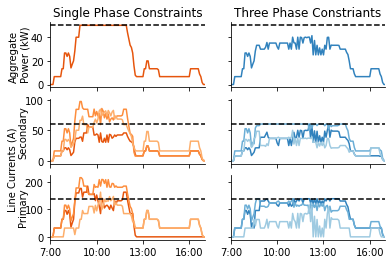

In [10]:
llf_fig = plot_currents(llf_sp_sim, llf_tp_sim, 208)

In [ ]:
llf_fig.savefig(f"figures/llf_single_v_three_phase.pdf", dpi=300)

### Model Predictive Control

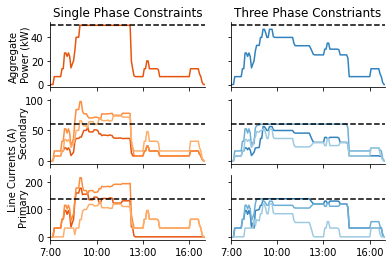

In [11]:
mpc_fig = plot_currents(mpc_sp_sim, mpc_tp_sim, 208)

In [ ]:
mpc_fig.savefig(f"figures/mpc_single_v_three_phase.pdf", dpi=300)

Here we can see that only considering single-phase constraints can lead to significant constraint violations in line currents for both algorithms. However, by designing an algorithm which considers the full three-phase model, we are able to respect these constraints. Note that because of phase unbalance, we are not able to make use of the full 50 kW transformer capacity while also respecting line limits, though MPC does get closer to fully utilizing the available capacity.